In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt
from scipy.stats import beta
from IPython.core.pylabtools import figsize

plt.xkcd();

# Bandit Algorithms: Getting More Lunch Money

## Artem Yankov
### Data Scientist at Rover.com

Contact me!

* yankovai@umich.edu
* 1oclockbuzz.com

## Outline

* A motivating example using Bayesian Bandits
* Other Bandit Algorithms
* Getting more lunch money
* Caveats
* References for further exploration

# An Example

## One-Armed Bandit

![](one_armed_bandit.jpg)

## Multi-Armed Bandit Problem

* Say we are faced with K one-armed bandits
* Each has an unknown payoff
* At each turn we choose a bandit and pull
    * The bandit either pays money out, or not
* What strategy should we use to optimize our earnings?

## Model the Problem

$$
\begin{equation}
P(r_i | n_i, w_i) = \frac{P(n_i, w_i | r_i)P(r_i)}{P(n_i, w_i)}
\end{equation}
$$

* Update our belief about each bandit's payoff rate as we continue playing
* Sounds like a problem for Bayes' Theorem
* $r_i =$ Payoff rate of bandit $i$
* $n_i =$ Number of times bandit $i$ has been played
* $w_i =$ Number of times we've won with bandit $i$

## Prior

* Seems natural to model the prior $P(r_i)$ as a beta distribution $\beta(a, b)$
    * Domain is from 0 to 1
* Initially we have no reason to believe one bandit pays out at a higher rate than the others
    * The beta distribution is the uniform distribution for $\beta(a=1, b=1)$ 

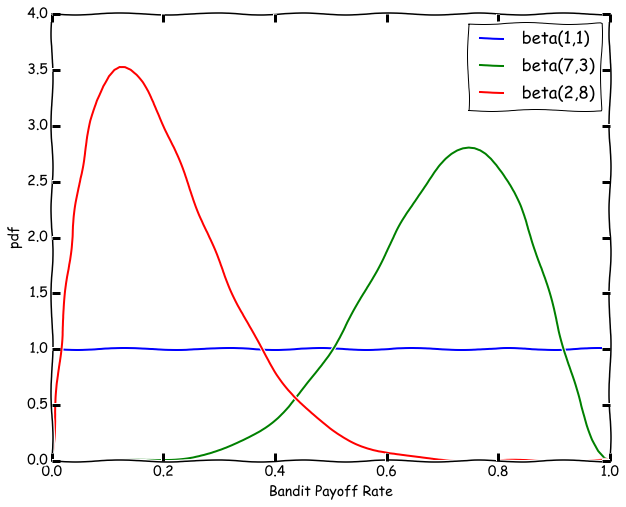

In [2]:
figsize(10,8)
x = np.linspace(0, 1, 100)
b_11, b_73, b_28 = beta(1, 1), beta(7, 3), beta(2, 8)
plt.plot(x, b_11.pdf(x), color='b', label='beta(1,1)')
plt.plot(x, b_73.pdf(x), color='g', label='beta(7,3)')
plt.plot(x, b_28.pdf(x), color='r', label='beta(2,8)')
plt.legend(loc='best')
plt.xlabel('Bandit Payoff Rate')
plt.ylabel('pdf');

## Likelihood

* Given an expected payoff rate, what's the probability of having $w_i$ wins out of $n_i$ trials?
    * The binomial distribution gives this to us
    
$$P(n_i, w_i | r_i) = {n_i \choose w_i}r_i^{w_i} (1 - r_i)^{n_i - w_i} $$

## Posterior

* The beta distribution is the conjugate prior for the binomial distribution
    * When you multiply the beta distribution by the binomial you get a beta distribution back!
* Skipping the math, if we assume a beta prior $\beta(a,b)$ the posterior becomes: 

$$P(r_i | n_i, w_i) = \beta(a + w_i, b + n_i - w_i)$$

## Bayesian Bandit Algorithm 

1. For each of K bandits, set $\beta(1,1)$ (uniform distribution)
2. At each turn:
    * Take a sample from each bandit's beta distribution
    * Choose the bandit that yielded the largest sample
    * Play the bandit
    * Update the bandit's distribution based on the result of the pull

## Simulation

* Say we have 3 bandits
    * Payoff of bandit 0 = 0.55
    * Payoff of bandit 1 = 0.71
    * Payoff of bandit 2 = 0.29
* Pretend the player faced with getting the most money out of the bandits doesn't know their true payoffs
* How does the bandit algorithm perform?

In [3]:
class Bandit:
    
    def __init__(self, r):
        self.r = r
        self.n = 0
        self.w = 0
        
    def pull(self):
        return (np.random.rand() < self.r)
    
    def update(self, result):
        self.n += 1
        if result:
            self.w += 1
            
    def sample(self):
        return (np.random.beta(1 + self.w, 1 + self.n - self.w))

In [4]:
def plot_bandit_pdfs(n_rounds, seed=3):
    np.random.seed(seed)
    k = 3
    bandits = map(Bandit, np.random.rand(k))

    for rnd in xrange(n_rounds):
        bandit_samps = [bandit.sample() for bandit in bandits]
        candidate_bandit = np.argmax(bandit_samps)
        result = bandits[candidate_bandit].pull()
        bandits[candidate_bandit].update(result)

    fig, axes = plt.subplots(1, k, sharey=True)
    x = np.linspace(0, 1, 100)
    for i, ax in enumerate(axes):
        w = bandits[i].w
        n = bandits[i].n
        r = bandits[i].r
        y = beta(1 + w, 1 + n - w).pdf(x)
        ax.plot(x, y)
        ax.set_title('Bandit {0}\n n={1}, w={2}, r={3:4.2f}'.format(i, n, w, r))
        ax.axvline(bandits[i].r, color='b', linestyle='--')
    
    plt.show();

### Bandit PDFs

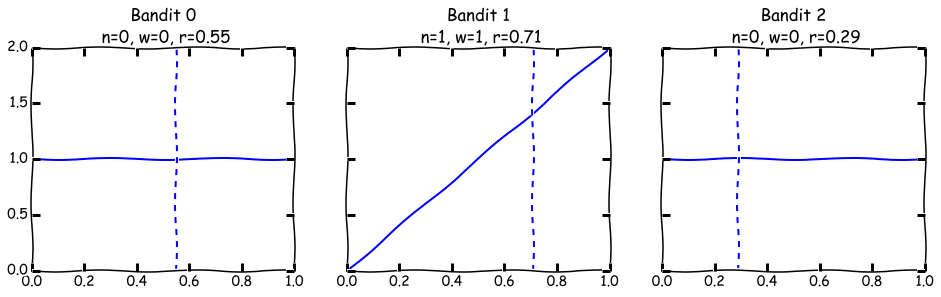

In [5]:
figsize(16,4)
plot_bandit_pdfs(n_rounds=1)

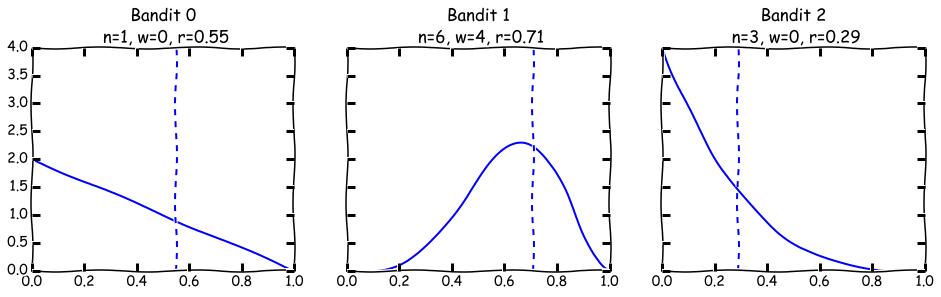

In [6]:
figsize(16,4)
plot_bandit_pdfs(n_rounds=10)

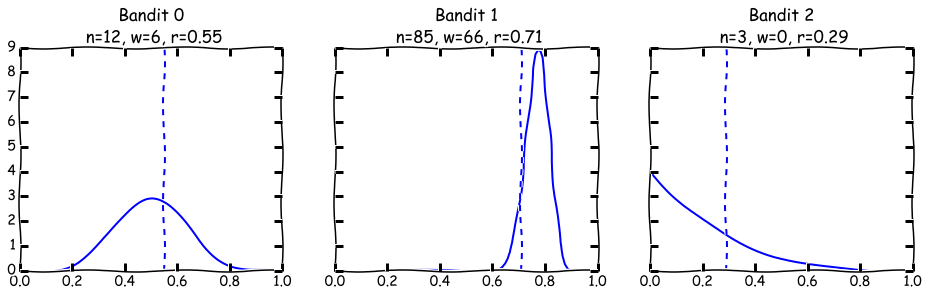

In [7]:
figsize(16,4)
plot_bandit_pdfs(n_rounds=100)

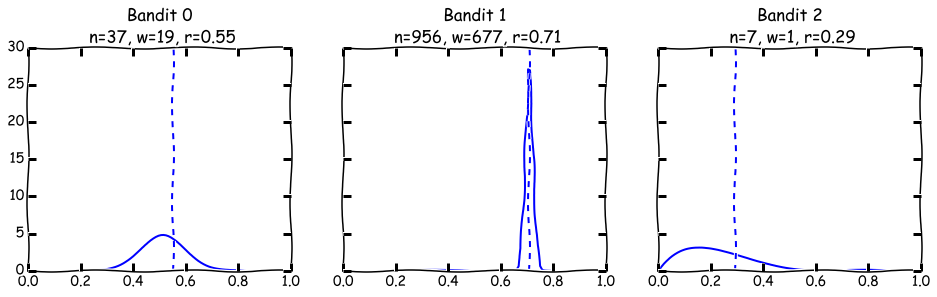

In [8]:
figsize(16,4)
plot_bandit_pdfs(n_rounds=1000)

In [9]:
def analyze_bandits(n_rounds, n_sims, seed=3, alg_type='bandit'):  
    k = 3
    results = {'reward': np.zeros([n_rounds, n_sims]),
               'chosen_bandit': np.zeros([n_rounds, n_sims])}
    
    if alg_type == 'bandit':
        for sim in xrange(n_sims):
            # Reset bandits
            np.random.seed(seed)
            bandits = map(Bandit, np.random.rand(k))
            np.random.seed()
            for rnd in xrange(n_rounds):
                bandit_samps = [bandit.sample() for bandit in bandits]
                candidate_bandit = np.argmax(bandit_samps)
                result = bandits[candidate_bandit].pull()
                bandits[candidate_bandit].update(result)

                # Store results
                results['reward'][rnd, sim] = result
                results['chosen_bandit'][rnd, sim] = candidate_bandit
    elif alg_type == 'random':
        for sim in xrange(n_sims):
            # Reset bandits
            np.random.seed(seed)
            bandits = map(Bandit, np.random.rand(k))
            np.random.seed()
            for rnd in xrange(n_rounds):
                candidate_bandit = np.random.randint(0, k)
                result = bandits[candidate_bandit].pull()
                bandits[candidate_bandit].update(result)

                # Store results
                results['reward'][rnd, sim] = result
                results['chosen_bandit'][rnd, sim] = candidate_bandit
    
    bandit_payoff_rates = [b.r for b in bandits]          
    return (results, bandit_payoff_rates)

def plot_avg_reward(bresults, rresults, n_rounds):
    avg_breward = bresults['reward'].mean(axis=1)
    avg_rreward = rresults['reward'].mean(axis=1)
    plt.plot(range(n_rounds), avg_breward, label='Bandit')
    plt.plot(range(n_rounds), avg_rreward, label='Random')
    plt.legend(loc='best')
    plt.xlabel('Round')
    plt.ylabel('Average Reward')
    plt.show();
    
def plot_chosen_bandit(bresults, rresults, n_rounds, n_sims):
    for alg_type, results in zip(('Bandit', 'Random'), (bresults, rresults)):
        chosen_bandits = {i: (results['chosen_bandit'] == i).sum(axis=1)/float(n_sims) for i in range(3)}
        plt.figure()
        for i in range(3):
            plt.plot(range(n_rounds), chosen_bandits[i], label='Bandit {0}'.format(i))

        plt.legend(loc='best')
        plt.title('{0} Algorithm'.format(alg_type))
        plt.xlabel('Round')
        plt.ylabel('Fraction of Simulations Where Bandit is Chosen')
        plt.show();
        
def plot_cuml_regret(bresults, rresults, max_bandit_rate, n_rounds):
    bregret = np.cumsum(max_bandit_rate - bresults['reward'].mean(axis=1))
    plt.plot(range(n_rounds), bregret, label='Bandit')
    rregret = np.cumsum(max_bandit_rate - rresults['reward'].mean(axis=1)) 
    plt.plot(range(n_rounds), rregret, label='Random')
    plt.legend(loc='best')
    plt.xlabel('Round')
    plt.ylabel('Cumulative Regret At Round')
    plt.show();

N_SIMS = 5000
N_ROUNDS = 200
bresults, bandit_payoff_rates = analyze_bandits(n_rounds=N_ROUNDS, n_sims=N_SIMS, alg_type='bandit')
rresults, _ = analyze_bandits(n_rounds=N_ROUNDS, n_sims=N_SIMS, alg_type='random')

## Analysis

### Average Reward

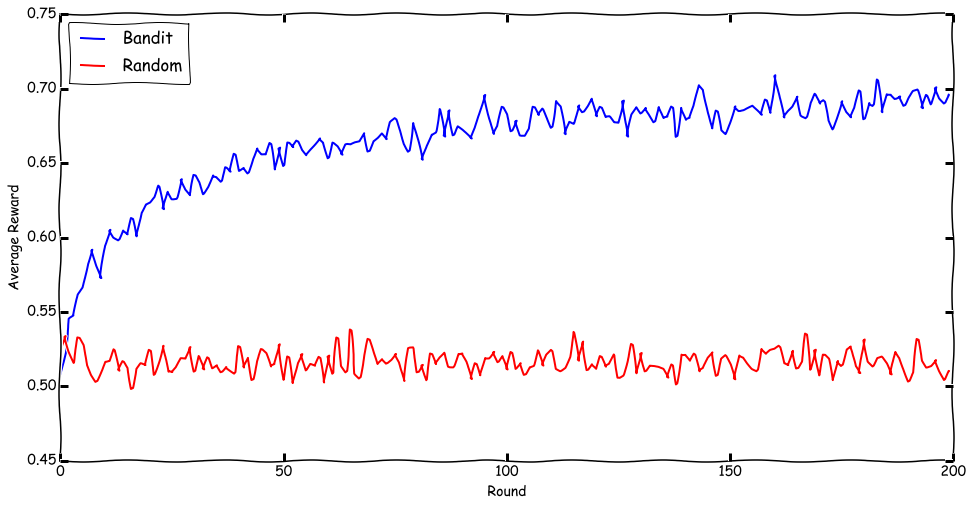

In [10]:
figsize(16,8)
plot_avg_reward(bresults, rresults, n_rounds=N_ROUNDS)

### Fraction of Time Each Bandit is Chosen

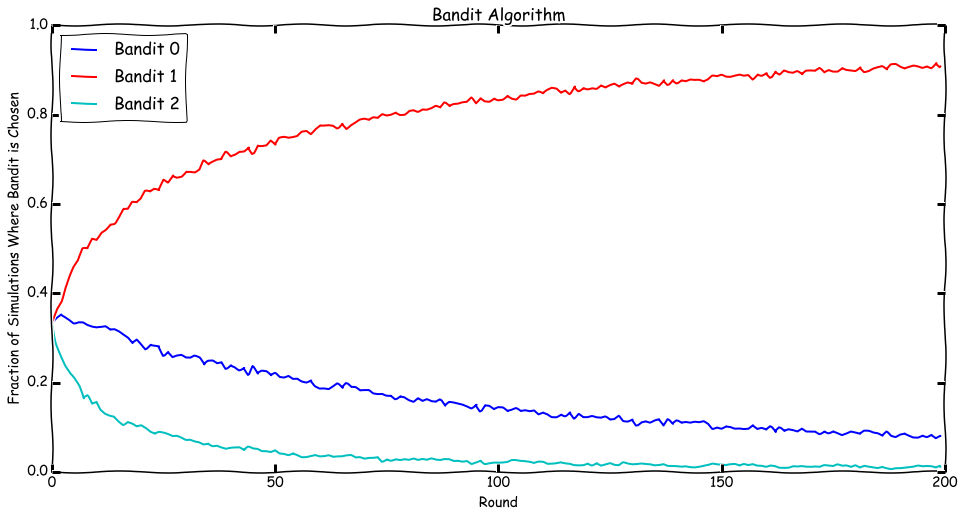

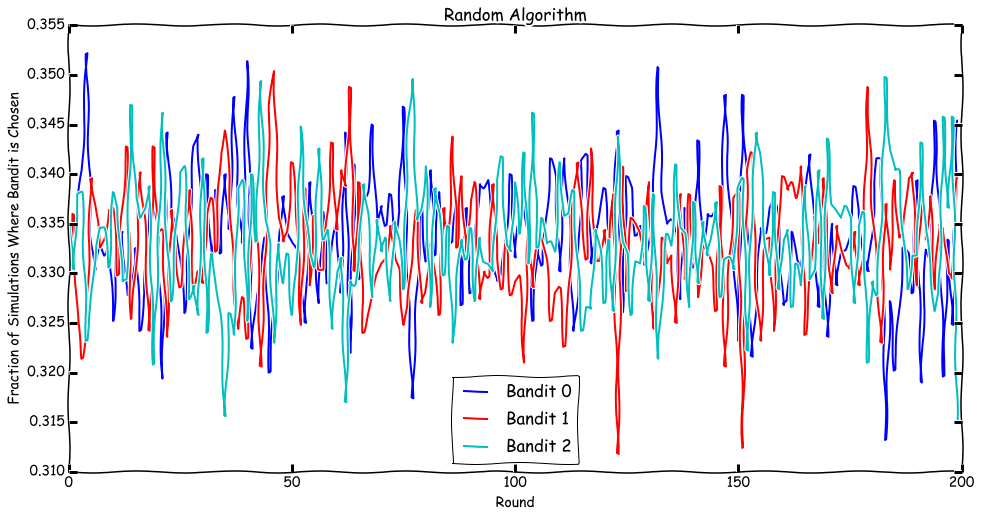

In [11]:
figsize(16,8)
plot_chosen_bandit(bresults, rresults, n_rounds=N_ROUNDS, n_sims=N_SIMS)

### Cumulative Regret

* Captures lost earnings if you were an omnipotent player
* Any strategy that yields logarithmic growing regret is said to "solve" the Bandit Problem

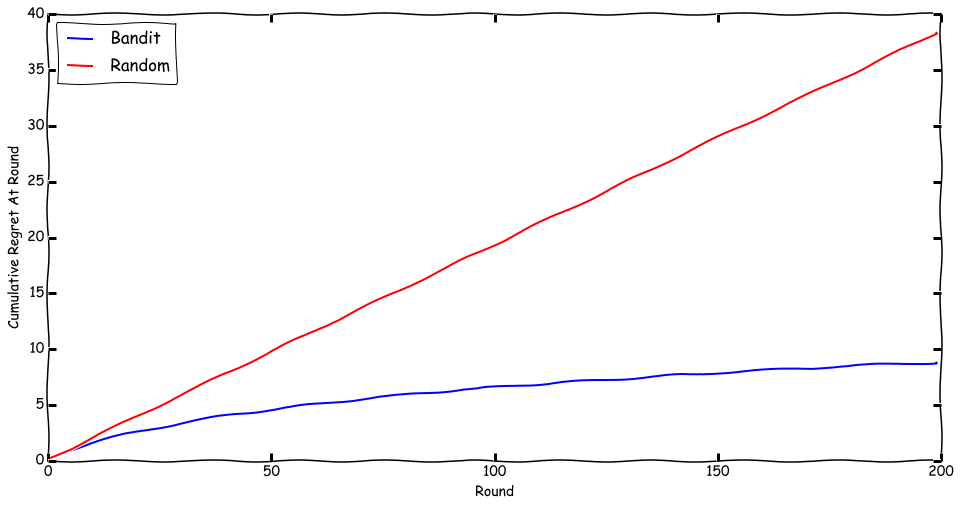

In [12]:
figsize(16,8)
plot_cuml_regret(bresults, rresults, max(bandit_payoff_rates), n_rounds=N_ROUNDS)

## Discussion

* Exploration vs Exploitation
* A/B Testing

# Other Bandit Algorithms

## Stochastic vs Adversarial Bandits

# A Little Theory

* Chernoff-Hoeffding bound
* epsilon-greedy
* ucb1


# Getting More Lunch Money

# Caveats

# Resources 